```bash
# create virtual environment
python -m venv venv

# activate it
source venv/bin/activate   # Mac/Linux
venv\Scripts\activate      # Windows

# install dependencies
pip install -r requirements.txt

# register jupyter env
python -m ipykernel install --user --name=caltech-venv --display-name "Caltech101 venv"
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from tqdm import tqdm
import math

class BaseClassifier(nn.Module):

    def __init__(self, criterion=None, optimizer=None, lr=1e-3):
        super().__init__()

        self.model = self.build_model()
        
        self.criterion = criterion or nn.CrossEntropyLoss()
        self.optimizer = optimizer or optim.Adam(self.model.parameters(), lr=lr)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def train_one_epoch(self, loader):

        self.model.train()
        total_loss = 0
        total_correct = 0

        for X, Y in loader:
            
            X, Y = X.to(self.device), Y.to(self.device)

            outputs = self.model(X)
            loss = self.criterion(outputs, Y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * X.size(0)
            total_correct += outputs.argmax(1).eq(Y).sum().item()

        return total_loss / len(loader.dataset), total_correct / len(loader.dataset)
    
    def evaluate(self, loader):

        self.model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X, Y in loader:
                X, Y = X.to(self.device), Y.to(self.device)

                outputs = self.model(X)
                loss = self.criterion(outputs, Y)

                total_loss += loss.item() * X.size(0)
                total_correct += outputs.argmax(1).eq(Y).sum().item()

        return total_loss / len(loader.dataset), total_correct / len(loader.dataset)
    
    def fit(self, train_loader, test_loader, epochs, writer):

        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
        
        for epoch in tqdm(range(epochs), unit="epoch", colour="green"):
            train_loss, train_acc = self.train_one_epoch(train_loader)
            test_loss, test_acc = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            writer.add_scalars("Loss", {"train": train_loss, "test": test_loss}, epoch)
            writer.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)

            if epoch % 5 == 0:
                self.log_misclassified(test_loader, writer, epoch)
                
            # print(f"Epoch {epoch+1}/{epochs} "
            #       f"| Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
            #       f"| Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

        # Final log
        if epoch % 5 != 0:
            self.log_misclassified(test_loader, writer, epoch)

        return (train_losses, test_losses, train_accuracies, test_accuracies)

    def log_misclassified(self, dataloader, writer, epoch):

        self.model.eval()

        misclassified = []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                outputs = self.model(images)
                preds = outputs.argmax(1)
                mask = preds != labels

                if mask.any():
                    misclassified.append(images[mask].cpu())

        # Concatenate all batches
        misclassified = torch.cat(misclassified, dim=0)

        num_images = misclassified.shape[0]

        # Make image grid
        img_grid = make_grid(misclassified, nrow=math.ceil(math.sqrt(num_images)), normalize=True)

        writer.add_image(f"Predictions/misclassified", img_grid, epoch)
            
    def build_model(self):
        raise NotImplementedError("")

In [2]:
import matplotlib.pyplot as plt

def plot_training(metrics):

    train_losses, test_losses, train_accs, test_accs = metrics

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # ---------------- LOSS ----------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # ---------------- ACCURACY ----------------
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("Caltech_101/", transform=transform)

In [4]:
import random
from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Mapping: class_index -> list of indices belonging to that class
class_to_indices = {i: [] for i in range(len(dataset.classes))}
for idx, (_, label) in enumerate(dataset):
    class_to_indices[label].append(idx)

train_indices = []
test_indices = []

for label, indices in class_to_indices.items():
    random.shuffle(indices)
    train_indices.extend(indices[:15])
    test_indices.extend(indices[15:30])  # next 15

train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

First, simple CNN based on LeNet (course)

In [6]:
# LeNet
class SimpleCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [01:08<00:00,  3.41s/epoch]


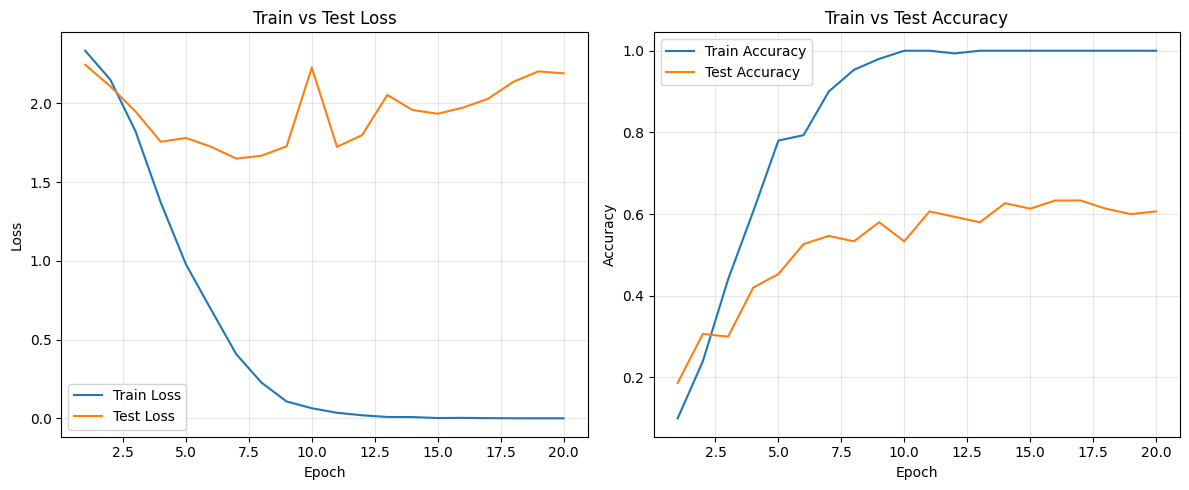

In [8]:
from torch.utils.tensorboard import SummaryWriter

EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/SimpleCNN")

simple_cnn = SimpleCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

```bash
# Training logs
tensorboard --logdir runs/SimpleCNN
```

___

Deeper network (Add 1 Conv layer and 1 Dense layer)

In [9]:
class DeeperCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(16, 32, (5,5)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(18432, 200), nn.ReLU(),
            nn.Linear(200, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

  0%|          | 0/30 [00:00<?, ?epoch/s]

100%|██████████| 30/30 [01:51<00:00,  3.70s/epoch]


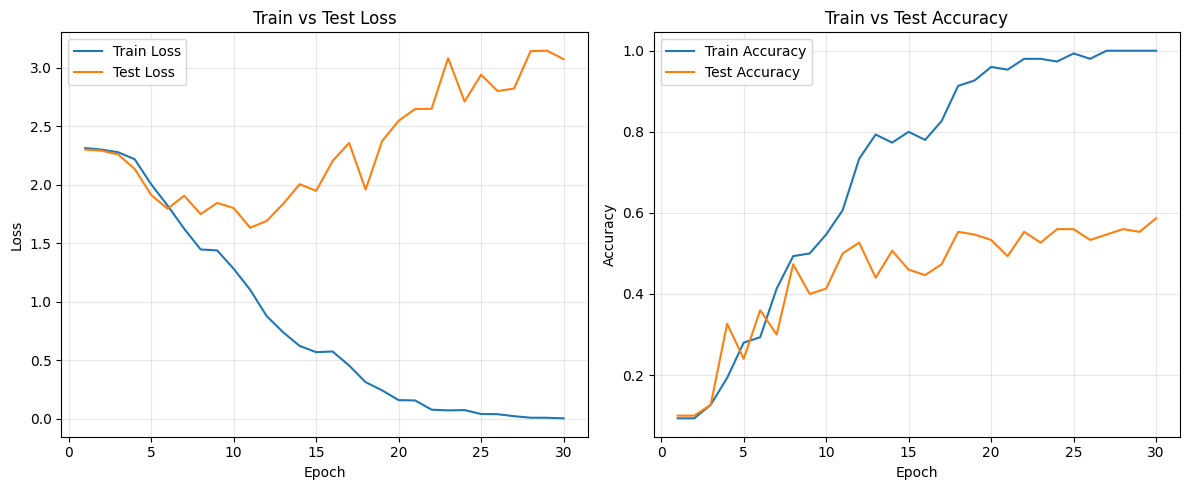

In [10]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/DeeperCNN")

simple_cnn = DeeperCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

-> Longer to train, does not improve the test accuracy

___

Use strided convolutions instead of max pooling

In [11]:
class StridedCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (5,5), stride=2), nn.ReLU(),
            nn.Conv2d(6, 16, (5,5), stride=2), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(44944, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [00:38<00:00,  1.92s/epoch]


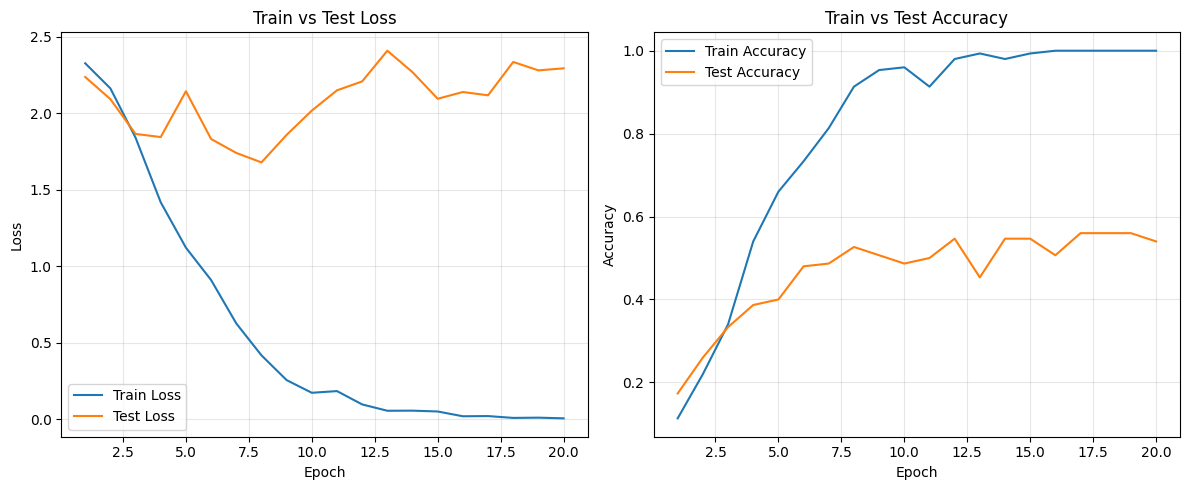

In [13]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/StridedCNN")

simple_cnn = StridedCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

-> Similar with the base one, maybe slightly worse

___

Reduce the filter size -> Preserve more locality information

In [14]:
class SmallKernelCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 16, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(46656, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [01:07<00:00,  3.35s/epoch]


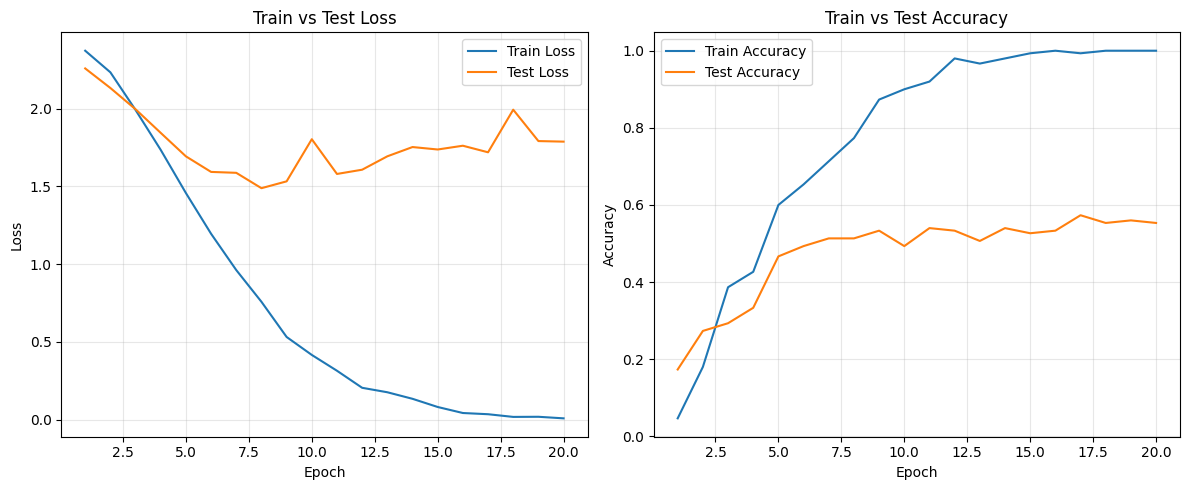

In [16]:
EPOCHS = 20
writer = SummaryWriter(log_dir=f"runs/SmallKernelCNN")

simple_cnn = SmallKernelCNN()
metrics = simple_cnn.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Small kernel size but deeper

In [19]:
class SmallKernelDeepCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            nn.Conv2d(3, 6, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(6, 12, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(12, 24, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Conv2d(24, 48, (3,3)), nn.ReLU(), nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(6912, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 20/20 [01:04<00:00,  3.22s/epoch]


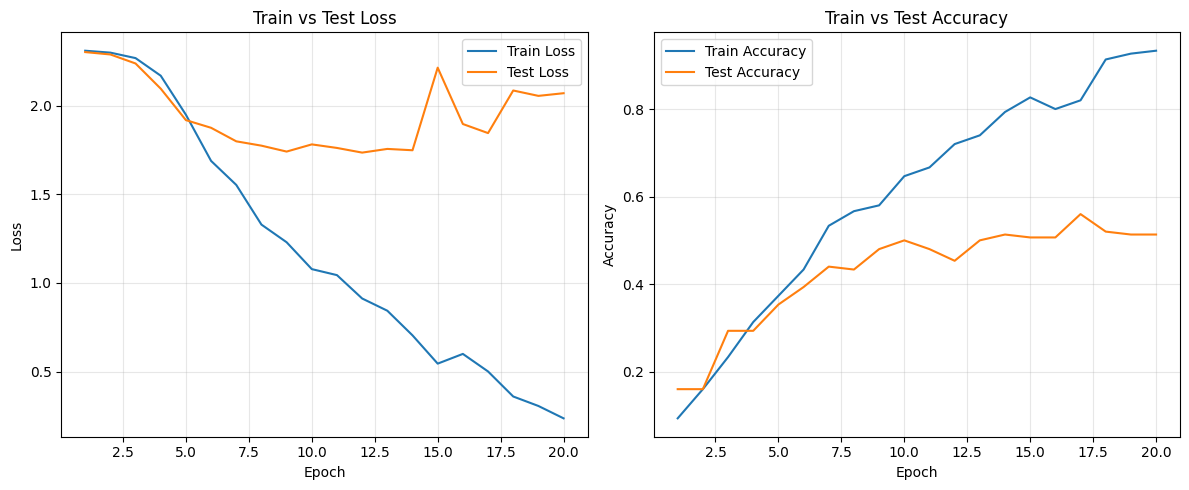

In [ ]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/SmallKernelDeepCNN")

classifier = SmallKernelDeepCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

___

Skipping Connections

In [31]:
class BasicResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.projection = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv(x)
        identity = self.projection(x)
        out += identity

        return self.relu(out)

class ResidualCNN(BaseClassifier):

    def __init__(self, criterion=None, optimizer=None, lr=0.001):
        super().__init__(criterion, optimizer, lr)

    def build_model(self):
        
        return nn.Sequential(
            BasicResidualBlock(3, 8),
            nn.MaxPool2d((2,2)),
            BasicResidualBlock(8, 16),
            nn.MaxPool2d((2,2)),
            nn.Flatten(start_dim=1),
            nn.Linear(50176, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 10)
        )

100%|██████████| 30/30 [03:51<00:00,  7.71s/epoch]


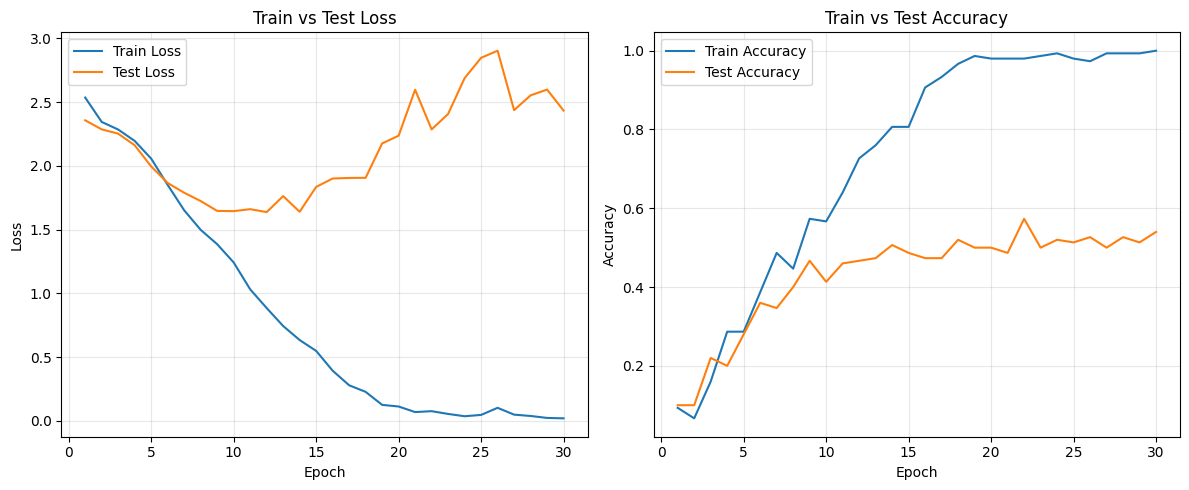

In [32]:
EPOCHS = 30
writer = SummaryWriter(log_dir=f"runs/ResidualCNN")

classifier = ResidualCNN()
metrics = classifier.fit(train_loader, test_loader, epochs=EPOCHS, writer=writer)
plot_training(metrics)

### TODO
- Batch Normalization / Layer Normalization
- Regularization : Weight decay / Dropout / Early-Stoping ?
- Squared hinge loss (🤷‍♂️?)
- SVD 
- Training parameters : batch_size / lr (should not change the asymptotic accuracy)
- Use pretrained model (isn't that cheating ?)